# Automatic Segmentation

## Imports
Import necessary libraries

In [1]:
import glob
import os

import numpy as np
import pandas as pd

import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Load Data
- Create dataframe
  - Images are of form `<case_id>_<slice_number>.tif`, and masks `<case_id>_<slice_number>_mask.tif`
- Data visualisation
  - Samples of images with positive and negative diagnosis
  - Samples of images and masks with a positive diagnosis 

### Create Dataframe

In [2]:
def get_diagnosis(mask_path: str) -> bool:
    """
    Diagnosis is positive if mask is anything but all black
    """
    return np.max(cv.imread(mask_path)) > 0

In [3]:
d = {"patient_id": [], "image_path": [], "mask_path": [], "diagnosis": []}

for sub_dir_path in glob.glob("Resources\Images\\" + "*"):
    if os.path.isdir(sub_dir_path):
        dir_name = sub_dir_path.split("\\")[-1]

        for im_name in os.listdir(sub_dir_path):
            if "mask" in im_name:
                continue

            mask_path = sub_dir_path + "\\" + im_name[:-4] + "_mask.tif"
            diagnosis = get_diagnosis(mask_path)

            d["patient_id"].append(dir_name)
            d["image_path"].append(sub_dir_path + "\\" + im_name)
            d["mask_path"].append(mask_path)
            d["diagnosis"].append(diagnosis)


df = pd.DataFrame(data=d)
df

,patient_id,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,False
1,TCGA_CS_4941_19960909,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,False
2,TCGA_CS_4941_19960909,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,True
3,TCGA_CS_4941_19960909,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,True
4,TCGA_CS_4941_19960909,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,Resources\Images\TCGA_CS_4941_19960909\TCGA_CS...,True
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,False
3925,TCGA_HT_A61B_19991127,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,False
3926,TCGA_HT_A61B_19991127,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,False
3927,TCGA_HT_A61B_19991127,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,Resources\Images\TCGA_HT_A61B_19991127\TCGA_HT...,False


### Visualise Data
Show samples of images with positive and negative diagnosis

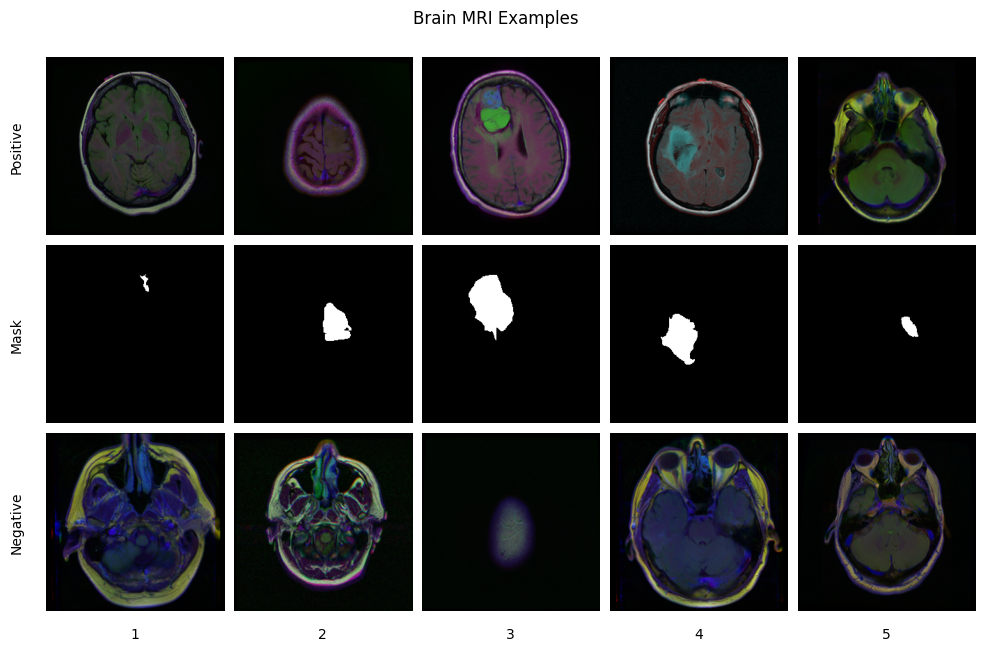

In [4]:
# Set how many samples to show
n_samples = 5

# Find examples of images with positive and negative diagnosis
sample_true_diagnosis = df[df["diagnosis"]].sample(n_samples)
sample_true_diagnosis_img = sample_true_diagnosis.image_path.values
sample_true_diagnosis_mask = sample_true_diagnosis.mask_path.values

sample_false_diagnosis_img = df[~df["diagnosis"]].sample(n_samples).image_path.values

# Display the images and their masks if positive
fig = plt.figure(figsize=(12, 10))
grid = ImageGrid(fig, 111, (3, n_samples), axes_pad=0.1)

for i, path in enumerate(sample_true_diagnosis_img):
    img_pos = plt.imread(path)
    mask = plt.imread(sample_true_diagnosis_mask[i])
    img_neg = plt.imread(sample_false_diagnosis_img[i])

    grid[i].imshow(img_pos)
    grid[n_samples + i].imshow(mask, cmap='gray')
    grid[2 * n_samples + i].imshow(img_neg)

    # Remove ticks and labels
    grid[i].axis("off")
    grid[n_samples + i].axis("off")
    grid[2 * n_samples + i].axis("off")

    # Add row labels on the left
    if i == 0:
        grid[i].text(-0.2, 0.5, "Positive", transform=grid[i].transAxes, va="center", rotation="vertical")
        grid[n_samples + i].text(-0.2, 0.5, "Mask", transform=grid[n_samples + i].transAxes, va="center", rotation="vertical")
        grid[2 * n_samples + i].text(-0.2, 0.5, "Negative", transform=grid[2 * n_samples + i].transAxes, va="center", rotation="vertical")

    # Add column index labels
    grid[2 * n_samples + i].text(0.5, -0.15, str(i + 1), transform=grid[2 * n_samples + i].transAxes, ha="center")

plt.suptitle("Brain MRI Examples")
plt.subplots_adjust(top=1.2)
plt.show()


## Pre-processing

### Data Generation

In [5]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.io import read_image

import albumentations as A

Set device for torch

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backend.mps.is_available()
    else "cpu"
)

print(f'Using device: {device}')

Using device: cuda


Define `training_data` and `test_data` by splitting the dataset randomly, in an 80:20 split respectively. 

In [7]:
training_data = df.sample(frac=0.8, random_state=200)
test_data = df.drop(training_data.index).sample(frac=1)

Create custom Dataset class

In [10]:
class BrainMRIDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = df.iloc(idx)['image_path']
        mask_path = df.iloc(idx)['mask_path']

        image = read_image(image_path)
        mask = read_image(mask_path)

        # Apply transforms to image and mask
        augmented = self.transforms(image=image, mask=mask)

        image = augmented['image']
        mask = augmented['mask']

        return image, mask


### Data Augmentation
- Rescale images to dimensions 256x256
- Normalise contrast
- Normalise intensities of tissues between cases
- Normalise z-score of entire dataset
- Convert to tensor

## Segmentation

## Post-processing

## Extraction of shape features